In [1]:
import os
import random
import numpy as np
import tensorflow as tf
seed = 1
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow_text as tf_text
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [4]:
def build_model():
  
    model = Sequential()
    model.add(Input(shape= (128, 768), name= 'embedding'))
    model.add(Conv1D(32, 5, activation ='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(6, activation ='softmax'))
    return model

In [5]:
def get_embedding(questions):
    
    text_input = tf.keras.layers.Input(shape=(), dtype = tf.string)
    preprocess_path = "D:/roberta/roberta_en_cased_preprocess_1"
    path = "D:/roberta/base"
    preprocess_model = hub.KerasLayer(preprocess_path)    
    encoder = hub.KerasLayer(path)
    
    encoder_inputs = preprocess_model(text_input)
    outputs = encoder(encoder_inputs)["sequence_output"] 

    embedding_model = tf.keras.Model(text_input, outputs)
    embeddings = embedding_model(tf.constant(questions))
    return embeddings

In [6]:
def evaluate_model(model, X_test, y_test):
    pred = model.predict(X_test)
    predicted_classes = np.argmax(pred, axis = 1)
    true_classes = np.argmax(y_test, axis = 1)
    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f"Accuracy: {accuracy}")
    f1_ = f1_score(true_classes, predicted_classes, average = 'weighted')
    print(f"F1 score: {f1_}")
    print(classification_report(true_classes, predicted_classes))

In [7]:
def plot_result(log_data): 
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['loss'], label ='train')
    plt.plot(log_data['val_loss'], label ='test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['accuracy'], label ='train')
    plt.plot(log_data['val_accuracy'], label ='test')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(log_data['f1_score'], label ='train')
    plt.plot(log_data['val_f1_score'], label ='test')
    plt.title('Model F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [8]:
questions = pd.read_csv('data/combined_dataset.csv')
questions

,QUESTION,BT LEVEL
0,"Suppose prices of two goods are constant, expl...",Comprehension
1,Explain the concept of price leadership observ...,Comprehension
2,Define profit. Briefly explain how accounting ...,Comprehension
3,Describe the assumptions of monopolistic compe...,Comprehension
4,Explain the meaning of the law of diminishing ...,Comprehension
...,...,...
2517,PEST and SWOT are popular strategy tools. Disc...,Application
2518,List the advantages and disadvantages of Publi...,Knowledge
2519,Show your calculations for all THREE (3) optio...,Analysis
2520,Currently the product life cycle for Apple iPo...,Evaluation


In [9]:
X = questions['QUESTION']
cognitive_level = {"Knowledge": 0, "Comprehension": 1, "Application": 2, "Analysis": 3, "Synthesis": 4, "Evaluation": 5}
questions["BT LEVEL"].replace(cognitive_level, inplace = True)
y = questions['BT LEVEL'].values

In [10]:
X_train, X_test, y_train, y_test  = train_test_split(X, y , test_size = 0.10, stratify = questions['BT LEVEL'], 
                                                                             shuffle = True, random_state = 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
X_train_roberta_base = get_embedding(X_train)
X_test_roberta_base = get_embedding(X_test)

In [12]:
np.save('embedding/roberta/embeddings-train.npy', X_train_roberta_base)
np.save('embedding/roberta/embeddings-test.npy', X_test_roberta_base)

In [13]:
X_train_roberta_base = np.load('embedding/roberta/embeddings-train.npy')
X_test_roberta_base = np.load('embedding/roberta/embeddings-test.npy')

In [14]:
#model
model = build_model()
# compiling the model
model.compile(optimizer = 'RMSprop', loss='categorical_crossentropy', metrics= ['accuracy', tfa.metrics.F1Score(6, 'weighted')])
# printing summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 124, 32)           122912    
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 123,110
Trainable params: 123,110
Non-trainable params: 0
_________________________________________________________________


In [15]:
training_logger = CSVLogger('log/Roberta/base/training.log', separator = ',', append = False)

In [16]:
# fit the model
model.fit(X_train_roberta_base, y_train, epochs = 50, batch_size = 8, validation_data = (X_test_roberta_base, y_test),
                                                  callbacks = [training_logger], verbose = 1)
#saving the trained model
model.save('saved_models/Roberta/base/EQCM.h5')

Epoch 1/50
284/284 [==============================] - 10s 23ms/step - loss: 1.0705 - accuracy: 0.6117 - f1_score: 0.6019 - val_loss: 0.8498 - val_accuracy: 0.7233 - val_f1_score: 0.7259
Epoch 2/50
284/284 [==============================] - 9s 33ms/step - loss: 0.5314 - accuracy: 0.8242 - f1_score: 0.8230 - val_loss: 0.8381 - val_accuracy: 0.7391 - val_f1_score: 0.7377
Epoch 3/50
284/284 [==============================] - 9s 33ms/step - loss: 0.3011 - accuracy: 0.9066 - f1_score: 0.9063 - val_loss: 0.6844 - val_accuracy: 0.7905 - val_f1_score: 0.7874
Epoch 4/50
284/284 [==============================] - 11s 37ms/step - loss: 0.1817 - accuracy: 0.9537 - f1_score: 0.9536 - val_loss: 0.8183 - val_accuracy: 0.7628 - val_f1_score: 0.7680
Epoch 5/50
284/284 [==============================] - 10s 36ms/step - loss: 0.0956 - accuracy: 0.9780 - f1_score: 0.9780 - val_loss: 0.8541 - val_accuracy: 0.8024 - val_f1_score: 0.8019
Epoch 6/50
284/284 [==============================] - 10s 36ms/step - lo

In [17]:
log_data = pd.read_csv('log/Roberta/base/training.log', sep = ',', engine = 'python')
log_data.head(50)

,epoch,accuracy,f1_score,loss,val_accuracy,val_f1_score,val_loss
0,0,0.611723,0.601881,1.070544e+00,0.723320,0.725900,0.849832
1,1,0.824152,0.823046,5.314165e-01,0.739130,0.737692,0.838095
2,2,0.906567,0.906264,3.010601e-01,0.790514,0.787379,0.684437
3,3,0.953724,0.953642,1.816722e-01,0.762846,0.767961,0.818350
4,4,0.977964,0.977966,9.558185e-02,0.802372,0.801857,0.854053
5,5,0.988541,0.988541,5.634228e-02,0.814229,0.814093,0.762262
6,6,0.995593,0.995587,2.820957e-02,0.818182,0.815350,0.934448
7,7,0.998678,0.998679,1.361156e-02,0.794466,0.794900,1.051554
8,8,0.998237,0.998237,9.015072e-03,0.786561,0.780492,1.208216
9,9,0.998237,0.998237,7.619903e-03,0.798419,0.795384,1.071187


In [18]:
log_data['val_accuracy'].describe()

count    50.000000
mean      0.816126
std       0.024395
min       0.723320
25%       0.814229
50%       0.822134
75%       0.830040
max       0.845850
Name: val_accuracy, dtype: float64

In [19]:
log_data['val_f1_score'].describe()

count    50.000000
mean      0.814973
std       0.023920
min       0.725900
25%       0.812154
50%       0.821170
75%       0.828860
max       0.844955
Name: val_f1_score, dtype: float64

In [20]:
model.load_weights("saved_models/Roberta/base/EQCM.h5")
evaluate_model(model, X_test_roberta_base, y_test)

8/8 [==============================] - 1s 40ms/step
Accuracy: 0.8221343873517787
F1 score: 0.8212482674133428
              precision    recall  f1-score   support

           0       0.78      0.83      0.81        35
           1       0.87      0.85      0.86        96
           2       0.80      0.62      0.70        32
           3       0.89      0.83      0.86        30
           4       0.70      0.93      0.80        28
           5       0.81      0.81      0.81        32

    accuracy                           0.82       253
   macro avg       0.81      0.81      0.81       253
weighted avg       0.83      0.82      0.82       253



In [21]:
log_data[['val_accuracy']].idxmax() + 1

val_accuracy    36
dtype: int64

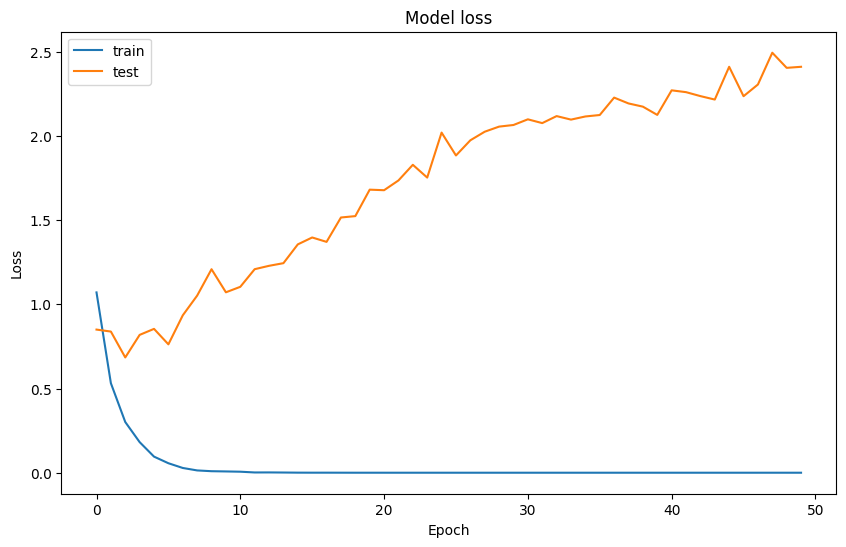

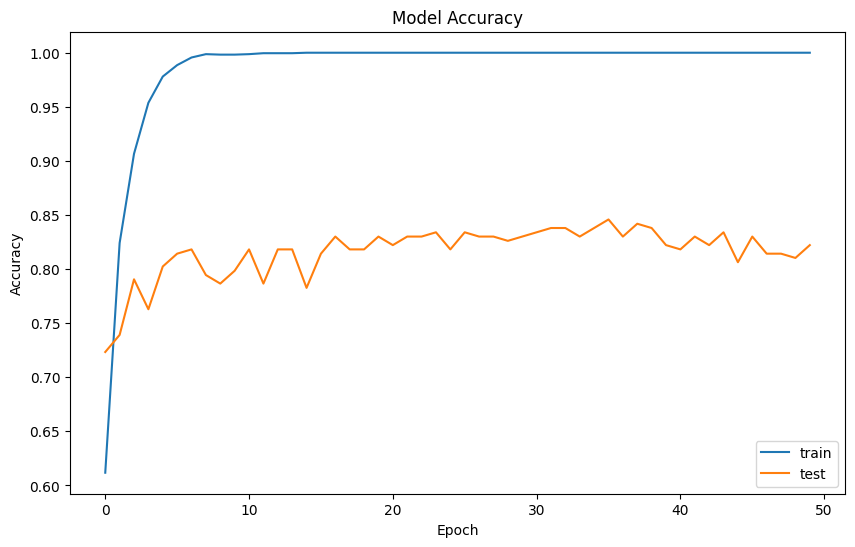

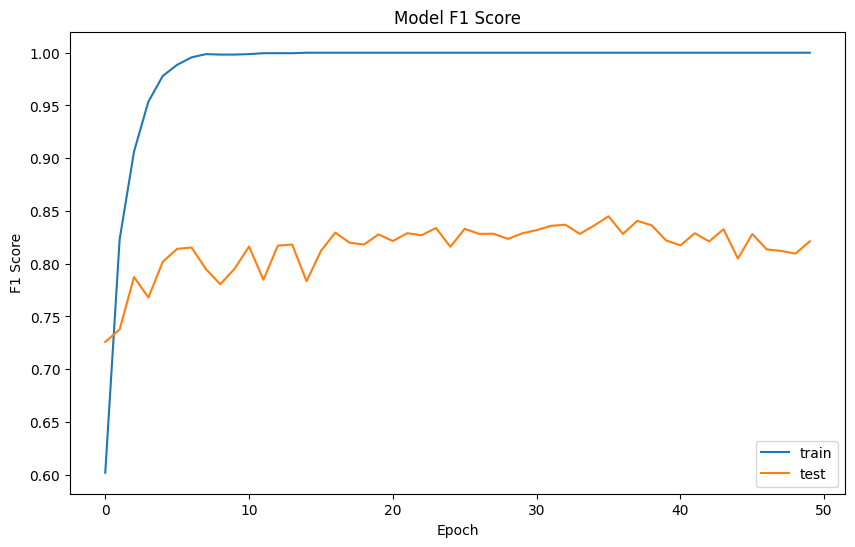

In [22]:
plot_result(log_data)